### Overview

This notebook uses **binary matrix factorization (BMF)** to identify latent recipes in the dataset.

The analyses are based on a binary matrix (X), with rows representing the recipes (size $n$), columns representing all the ingredients (size $p$); each entry is a boolean value indicating whether the corresponding ingredient is in that certain recipe. Note that we do not have access to cuisine labels in these analyses (thus unsupervised).

#### A brief intro to BMF

BMF is a special case of non-negative matrix factorization (a type of unsupervised learning methods). It tries to factorize binary matrix X into two matrices H and W :
$$
X \approx HW,
$$

where $X \in \mathbb{R}^{n \times p}$, $H \in \mathbb{R}^{n \times r}$ and $W \in \mathbb{R}^{r \times p}$.

In the case of this dataset, this can be seen as finding $r$ latent recipes, with basis matrix $W$ describing their tendency to have each ingredient, and mixture matrix $H$ quantifying how each recipe can be seen as a weighted combination of the latent recipes.

A more detailed description of BMF (and its comparison with other unsupervised learning methods) can be found in [Zhang et al. (2007)](https://ieeexplore.ieee.org/abstract/document/4470263).

#### Prerequisite

We use python package [Nimfa](http://nimfa.biolab.si/) to implement the BMF method. To run this notebook, you need to first install Nimfa via `pip install nimfa`.

#### Relationship with other jupyter notebooks and other files in the repository

Later when examining the analysis results, it will be helpful to have the notebook `DataExploration.ipynb` (specifically the secion "The most common ingredients in each cuisine") open to compare the ingredients in latent recipes to the common ingredients in each cuisine .

Folder `BMFresults/` have all the results of running the BMF models with different numbers of latent recipes (only the W matrices for now; will add the H matrices if we end up analyzing them). Fitting all these models will take forever locally... I ran them on the cluster and saved the results, so we can just load in the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nimfa

### Load the data

In [2]:
data = pd.read_json('train.json')
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Create a binary matrix indicating whether or not an ingredient is in a recipe

In [3]:
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Binary matrix facterization (using package nimfa)

#### Try 6 latent components ("latent" recipes)

In [4]:
%%time

NComponent = 6
X = dataBinaryIngredients.values

# use default values for lambda_w and lambda_h, increase max_iter to 100 to make sure fitting converges
bmf = nimfa.Bmf(X, seed="nndsvd", rank=NComponent, max_iter=100, lambda_w=1.1, lambda_h=1.1)
bmf_fit = bmf()

/Users/mingyusong/anaconda3/envs/cos424/lib/python3.7/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/Users/mingyusong/anaconda3/envs/cos424/lib/python3.7/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


CPU times: user 16min 1s, sys: 2min 41s, total: 18min 42s
Wall time: 10min 38s


In [6]:
# get the two matrices
W = np.array(bmf_fit.coef())
H = np.array(bmf_fit.basis())

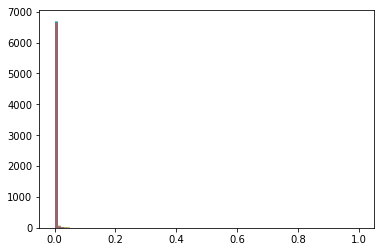

In [19]:
# most feature weights are very close to 0, i.e. weight matrix W is very sparse
for i in range(NComponent):
    sns.distplot(W[i,:], bins=np.linspace(0,1,101), label=i, kde=False)

In [9]:
# top (0.1%) ingredients for each "latent recipe"
print('Top ingredients for each "latent recipe":')
Ntop = 10
for i in range(NComponent):
    topIndices = np.where(W[i,:] > np.percentile(W[i,:], 99.9))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    # print the ingredients and their weights
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter' 'butter'
 'baking powder' 'milk'] [0.80031423 0.77347722 0.42743228 0.37916551 0.37514472 0.33897218
 0.25870744]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'vegetable oil'] [0.97898678 0.6086343  0.18198474 0.17025485 0.14434273 0.13881632
 0.12238046]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion'] [0.93341646 0.59477419 0.32937025 0.13827699 0.13744918 0.12089553
 0.11997928]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'eggs' 'black pepper' 'oil' 'flour'] [1.05014124 0.2701847  0.11458608 0.08254085 0.06046895 0.05168506
 0.05016358]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'salt' 'vegetable oil' 'oil'
 'chopped onion'] [1.00357722 0.05137566 0.03993033 0.0377805  0.03681479 0.03420766
 0.02965419]
Latent re


**Some observations from NComponent = 6:**
- It picks out the some cuisines!! Just eyeballing the top ingredients, there seems to be the following mappings: latent recipe 1: southern-us; 2: mexican; 3: italian; 6: chinese. Interestingly (and also probably as expected?), these cuisines are the ones with the most recipes.
- Other latent recipes (4 and 5) don't seem to map to any specific cuisine, but are a collection of commonly used ingredients. Note that latent recipe 5 might seem an odd combination of ingredients, but if we look at the weights, it's only 'water' that has a very high weight, so we can probably think of this latent recipe just representing the common ingredient 'water'.

#### What about other values of NComponent?

(The complete results of NComponent = 2 to 20 can be found <a href='#moreNComponent'>here</a>.)

1. In general, if `NComponent` is too small, the latent recipes just pick out some common ingredients, which isn't super interesting.

Here is an example of NComponent = 2:

In [17]:
NComponent = 2

# load in BMF results
W = pd.read_csv('BMFresults/NComponents'+str(NComponent)+'_W.csv', header=None, index_col=False).values

# top ingredients for each "latent recipe" and their weights
print('Top ingredients for each "latent recipe":')
for i in range(NComponent):
    topIndices = np.where(W[i,:] > np.percentile(W[i,:], 99.9))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'sugar' 'all-purpose flour' 'butter' 'large eggs' 'eggs'
 'unsalted butter'] [0.80848312 0.71335787 0.66128501 0.45523304 0.35484499 0.30094422
 0.30065275]
Latent recipe 2 : ['salt' 'onions' 'olive oil' 'garlic' 'garlic cloves' 'water' 'pepper'] [0.73250573 0.49962053 0.45732962 0.4340472  0.32212044 0.30930382
 0.26627989]


2. With larger `NComponent` values, the model doesn't continue to pick out more cuisines as we increase `NComponent`; still only the major cuisines get picked out (e.g. italian, southern-us, mexican and chinese). The other latent recipes are usually very sparse with only one or a couple ingredient having weights close to 1, and others having very small weights; these 'stand-out' ingredients are usually the common ingredients.

Here is an example of NComponent = 15 (top 0.1% ingredients are shown, with an additional cutoff criterion of weight>0.1 to make the results more clear):

In [18]:
NComponent = 15

# load in BMF results
W = pd.read_csv('BMFresults/NComponents'+str(NComponent)+'_W.csv', header=None, index_col=False).values

# top ingredients for each "latent recipe" and their weights
print('Top ingredients for each "latent recipe":')
for i in range(NComponent):
    topIndices = np.where((W[i,:] > np.percentile(W[i,:], 99.9))&(W[i,:] > 0.1))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar'] [1.0001615]
Latent recipe 2 : ['garlic' 'onions'] [1.04728348 0.43421348]
Latent recipe 3 : ['olive oil'] [1.00010914]
Latent recipe 4 : ['butter' 'milk'] [1.00917809 0.13550916]
Latent recipe 5 : ['water'] [0.99720205]
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger'] [0.98835219 0.55217838 0.48252297 0.30626869 0.30043369 0.29290696
 0.24322356]
Latent recipe 7 : ['vegetable oil'] [1.00002379]
Latent recipe 8 : ['garlic cloves' 'onions'] [1.006723   0.25183557]
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado'] [0.7469894  0.51436138 0.32002288 0.29969831 0.27608738 0.26425783
 0.25773901]
Latent recipe 10 : ['salt'] [0.91667854]
Latent recipe 11 : ['pepper'] [0.99974241]
Latent recipe 12 : ['onions' 'eggs' 'oil' 'milk' 'salt' 'flour'] [0.41685365 0.39307138 0.19238655 0.1233020


**Summary for NComponent = 15:**
- Most latent recipes are very sparse (with only one ingredient having feature weight > 0.1)
- (Following the first point) common ingredients are picked out by these sparse latent recipes: e.g. sugar, salt, pepper, water, etc
- Major cuisines are picked out! latent recipe 6: chinese, 9: mexican, 14: italian, 15: southern-us.

### TODOs:

So far we've only looked at the weight matrix W. It might also be interesting to look at matrix H (the extend to which each recipe is "made up of" by the latent recipes).

### ========== The end of main results ========== 

<a id='moreNComponent'></a>
### Supplementary: BMF with various number of "latent recipes"

You can change the criteria for selecting what ingredients to show for each latent recipe: now I'm showing only top 0.1% AND weight>0.1.

N component = 2


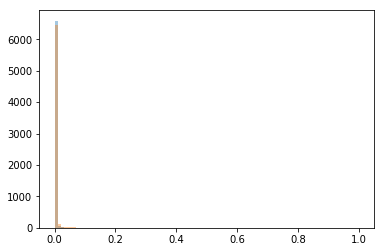

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'sugar' 'all-purpose flour' 'butter' 'large eggs' 'eggs'
 'unsalted butter']
Latent recipe 2 : ['salt' 'onions' 'olive oil' 'garlic' 'garlic cloves' 'water' 'pepper']

N component = 3


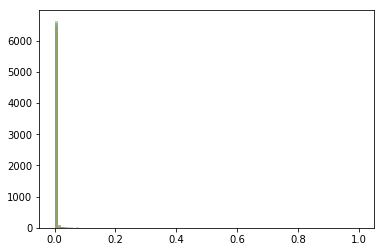

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'water' 'all-purpose flour' 'soy sauce' 'vegetable oil'
 'large eggs' 'unsalted butter']
Latent recipe 2 : ['onions' 'olive oil' 'garlic' 'garlic cloves' 'water'
 'ground black pepper' 'tomatoes']
Latent recipe 3 : ['salt' 'pepper' 'butter' 'all-purpose flour']

N component = 4


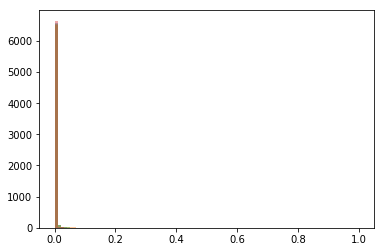

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'water' 'large eggs' 'soy sauce'
 'unsalted butter' 'baking powder']
Latent recipe 2 : ['onions' 'garlic' 'water' 'carrots' 'vegetable oil' 'tomatoes'
 'ground cumin']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper'
 'extra-virgin olive oil' 'kosher salt' 'grated parmesan cheese'
 'fresh parsley']
Latent recipe 4 : ['salt' 'pepper' 'butter']

N component = 5


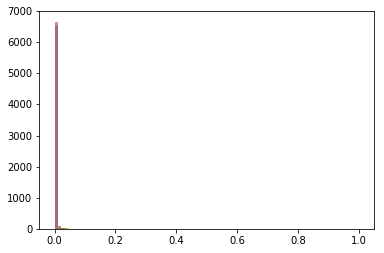

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'butter' 'eggs']
Latent recipe 2 : ['onions' 'garlic' 'carrots' 'vegetable oil' 'soy sauce' 'tomatoes'
 'ground cumin']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'salt'
 'extra-virgin olive oil' 'kosher salt' 'grated parmesan cheese']
Latent recipe 4 : ['salt' 'pepper' 'butter']
Latent recipe 5 : ['water']

N component = 6


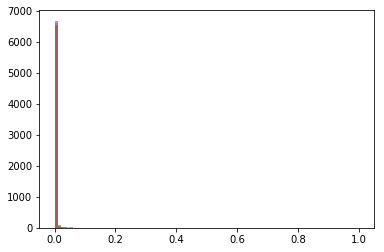

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter' 'butter'
 'baking powder' 'milk']
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'vegetable oil']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion']
Latent recipe 4 : ['salt' 'pepper' 'butter']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'garlic' 'sugar' 'vegetable oil'
 'scallions']

N component = 7


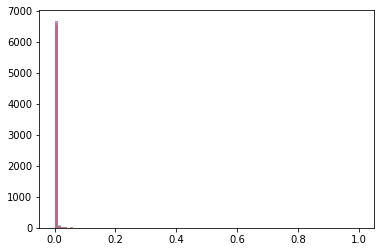

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'butter' 'unsalted butter'
 'baking powder' 'milk']
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'carrots' 'chili powder']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion']
Latent recipe 4 : ['salt' 'pepper' 'butter']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'garlic' 'sugar' 'scallions'
 'corn starch']
Latent recipe 7 : ['vegetable oil' 'garlic cloves' 'ground black pepper']

N component = 8


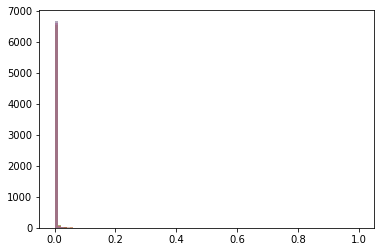

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'vanilla extract' 'milk']
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'salt' 'kosher salt'
 'grated parmesan cheese' 'extra-virgin olive oil']
Latent recipe 4 : ['salt' 'butter' 'eggs' 'all-purpose flour' 'milk' 'black pepper']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'garlic' 'scallions'
 'corn starch' 'rice vinegar']
Latent recipe 7 : ['vegetable oil' 'garlic cloves']
Latent recipe 8 : ['pepper' 'salt']

N component = 9


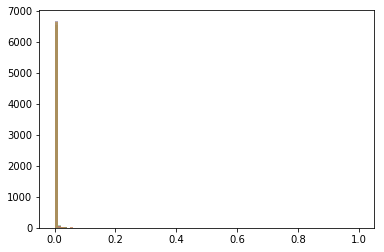

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'vanilla extract' 'baking soda']
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese' 'fresh parsley']
Latent recipe 4 : ['butter' 'eggs' 'all-purpose flour' 'milk' 'baking powder' 'flour' 'salt']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'garlic' 'scallions'
 'corn starch' 'rice vinegar']
Latent recipe 7 : ['vegetable oil' 'garlic cloves' 'all-purpose flour']
Latent recipe 8 : ['pepper' 'salt']
Latent recipe 9 : ['salt' 'ground black pepper']

N component = 10


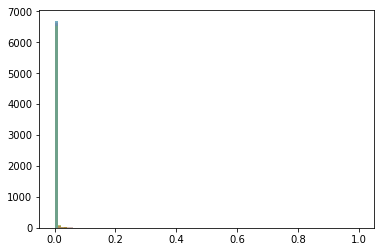

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda']
Latent recipe 2 : ['onions' 'garlic' 'carrots' 'ground black pepper' 'tomatoes']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese']
Latent recipe 4 : ['butter' 'eggs' 'all-purpose flour' 'milk' 'baking powder' 'white sugar'
 'flour']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'garlic' 'scallions'
 'corn starch' 'rice vinegar']
Latent recipe 7 : ['vegetable oil' 'garlic cloves' 'all-purpose flour']
Latent recipe 8 : ['pepper' 'salt']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']

N component = 11


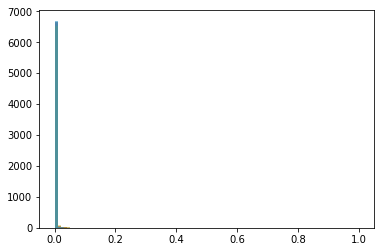

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda']
Latent recipe 2 : ['garlic' 'ground black pepper']
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese']
Latent recipe 4 : ['butter' 'all-purpose flour' 'eggs' 'milk' 'baking powder'
 'vanilla extract' 'white sugar']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil' 'all-purpose flour' 'garlic cloves']
Latent recipe 8 : ['onions' 'carrots' 'tomatoes']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper' 'salt']

N component = 12


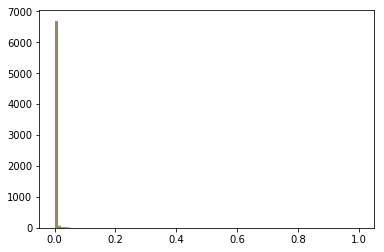

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract']
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'ground black pepper']
Latent recipe 3 : ['olive oil' 'ground black pepper' 'grated parmesan cheese']
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil' 'all-purpose flour']
Latent recipe 8 : ['garlic cloves' 'onions' 'extra-virgin olive oil']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper' 'salt']
Latent recipe 12 : ['eggs' 'milk' 'all-purpose flour' 'baking powder' 'flour' 'white sugar']

N component = 13


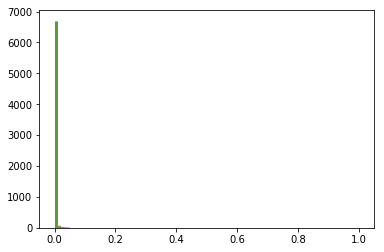

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda']
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'ground black pepper']
Latent recipe 3 : ['olive oil' 'ground black pepper' 'grated parmesan cheese']
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil' 'all-purpose flour']
Latent recipe 8 : ['garlic cloves' 'onions' 'extra-virgin olive oil']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['eggs' 'milk' 'flour' 'baking powder' 'white sugar']
Latent recipe 13 : ['black pepper']

N component = 14


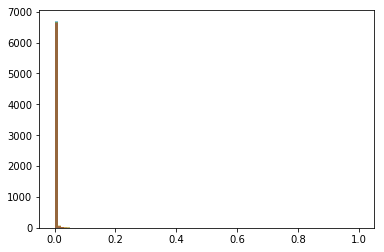

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract']
Latent recipe 2 : ['garlic' 'onions']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil' 'all-purpose flour']
Latent recipe 8 : ['garlic cloves' 'onions' 'carrots']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['eggs' 'milk' 'flour' 'oil']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['ground black pepper' 'kosher salt' 'extra-virgin olive oil']

N component = 15


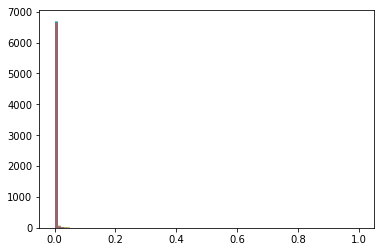

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic' 'onions']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['garlic cloves' 'onions']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['onions' 'eggs' 'oil' 'milk' 'salt' 'flour']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['ground black pepper' 'kosher salt' 'extra-virgin olive oil']
Latent recipe 15 : ['all-purpose flour' 'large eggs' 'unsalted butter' 'baking powder'
 'baking soda' 'buttermilk' 'vanilla extract']

N component = 16


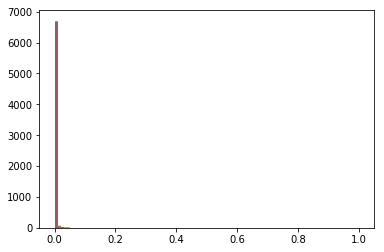

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'tomatoes']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['garlic cloves' 'onions']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['eggs' 'oil' 'milk' 'flour' 'onions']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['ground black pepper' 'kosher salt' 'extra-virgin olive oil']
Latent recipe 15 : ['all-purpose flour' 'large eggs' 'unsalted butter' 'baking powder'
 'baking soda' 'buttermilk' 'vanilla extract']
Latent recipe 16 : ['salt']

N component = 17


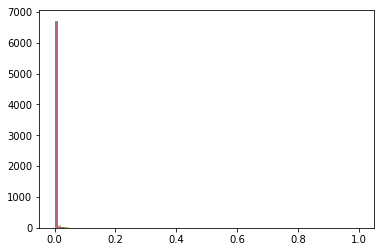

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'tomatoes']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk']
Latent recipe 5 : ['water']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['garlic cloves' 'onions']
Latent recipe 9 : ['ground cumin' 'chili powder' 'jalapeno chilies' 'tomatoes'
 'chopped cilantro fresh' 'sour cream' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['eggs' 'oil' 'onions' 'flour' 'milk']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['ground black pepper' 'kosher salt' 'extra-virgin olive oil']
Latent recipe 15 : ['large eggs' 'unsalted butter']
Latent recipe 16 : ['salt']
Latent recipe 17 : ['all-purpose flour' 'baking powder' 'baking soda' 'unsalted butter'
 'milk' 'buttermilk']

N component = 18


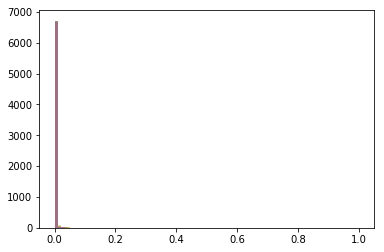

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk' 'eggs']
Latent recipe 5 : ['garlic cloves' 'extra-virgin olive oil']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['onions' 'carrots']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies' 'sour cream'
 'chopped cilantro fresh' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['salt']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['ground black pepper' 'kosher salt' 'extra-virgin olive oil']
Latent recipe 15 : ['large eggs' 'unsalted butter']
Latent recipe 16 : ['salt']
Latent recipe 17 : ['all-purpose flour' 'baking powder' 'eggs' 'milk' 'baking soda'
 'unsalted butter' 'buttermilk']
Latent recipe 18 : ['water']

N component = 19


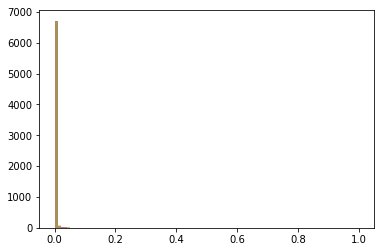

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk' 'eggs']
Latent recipe 5 : ['garlic cloves']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['onions' 'carrots']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies' 'sour cream'
 'chopped cilantro fresh' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['salt']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['extra-virgin olive oil' 'kosher salt' 'fresh lemon juice'
 'flat leaf parsley' 'purple onion' 'freshly ground pepper' 'tomatoes']
Latent recipe 15 : ['large eggs' 'unsalted butter']
Latent recipe 16 : ['salt']
Latent recipe 17 : ['all-purpose flour' 'baking powder' 'eggs' 'milk' 'baking soda'
 'unsalted butter' 'buttermilk']
Laten

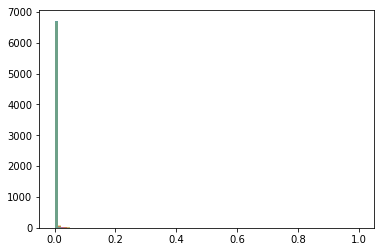

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar']
Latent recipe 2 : ['garlic']
Latent recipe 3 : ['olive oil']
Latent recipe 4 : ['butter' 'milk' 'eggs']
Latent recipe 5 : ['garlic cloves']
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger']
Latent recipe 7 : ['vegetable oil']
Latent recipe 8 : ['onions' 'carrots']
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies' 'sour cream'
 'chopped cilantro fresh' 'avocado']
Latent recipe 10 : ['salt']
Latent recipe 11 : ['pepper']
Latent recipe 12 : ['salt']
Latent recipe 13 : ['black pepper']
Latent recipe 14 : ['extra-virgin olive oil' 'kosher salt' 'fresh lemon juice'
 'flat leaf parsley' 'purple onion' 'freshly ground pepper']
Latent recipe 15 : ['large eggs' 'unsalted butter']
Latent recipe 16 : ['salt']
Latent recipe 17 : ['all-purpose flour' 'baking powder' 'eggs' 'milk' 'baking soda'
 'unsalted butter' 'buttermilk']
Latent recipe 18

In [15]:
for NComponent in np.arange(1,20)+1:

    print('N component =', NComponent)

    # load in BMF results
    W = pd.read_csv('BMFresults/NComponents'+str(NComponent)+'_W.csv', header=None, index_col=False).values
#     H = pd.read_csv('BMFresults/NComponents'+str(NComponent)+'_H.csv', header=None, index_col=False).values

    # histogram of feature weights for each "latent recipe"
    for i in range(NComponent):
        sns.distplot(W[i,:], bins=np.linspace(0,1,101), label=i, kde=False)
    plt.show()

    # top ingredients for each "latent recipe"
    print('Top ingredients for each "latent recipe":')
    for i in range(NComponent):
        topIndices = np.where((W[i,:] > np.percentile(W[i,:], 99.9))&(W[i,:] > 0.1))[0]
        topIndices = topIndices[np.argsort(-W[i, topIndices])]
        print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices]) #, W[i, topIndices]
    
    print('')